![](logo_scanpy.svg){width=50% fig-align="center"}

이번 실습에서는 데이터의 시각화를 위한 차원축소 방법인 PCA, tSNE, UMAP등에 대해 배우고 
배치 효과를 제거해서 여러 데이터셋을 통합하는 방법에 대해 살펴봅니다.

# 들어가며

이 글은 [NBIS workshop](https://nbisweden.github.io/workshop-scRNAseq) 자료를 기반으로 수정 및 번역 작업을 진행한것입니다. 가장 먼저 필요한 라이브러리와 QC를 진행한 데이터 파일을 불러오도록 하겠습니다.

In [1]:
import warnings

import bbknn
import matplotlib.pyplot as plt
import numpy as np
import scanorama
import scanpy as sc

# 경고 무시하기
warnings.filterwarnings("ignore")
sc.settings.n_jobs = -1
sc.settings.verbosity = 0  # 오류 (0), 경고 (1), 정보 (2), 힌트 (3)
sc.settings.set_figure_params(
    dpi=60, frameon=False, figsize=(5, 5), facecolor="white", color_map="viridis_r"
)
print(f"사용한 SCANPY 버전: {sc.__version__}")

사용한 SCANPY 버전: 1.10.1


/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/scRNAseq/notebook_2024/scRNA_workshop/.pixi/envs/default/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_file = "./output/covid/results/scanpy_covid_qc.h5ad"
adata = sc.read_h5ad(path_file)

print(f"데이터의 수: {adata.n_obs}, 유전자의 수: {adata.n_vars}")

데이터의 수: 7227, 유전자의 수: 19094


혹시 `adata.X`의 값이 정규화되지 않았는지 아래 코드로 확인합니다.

In [3]:
np.max(adata.X)

21145.0

정규화되지 않은 원시 카운트 값이 확인이 되네요. 이 값을 다른 레이어로 저장하고 결측치(값이 없는 데이터)가 있는지 확인해봅니다.

In [4]:
# 원본 Count 값을 새로운 레이어로 저장
adata.layers["counts"] = adata.X.copy()
# X 및 var의 원본을 .raw.X 및 .raw.var로 저장.
adata.raw = adata

# 행이나 열방향으로 0으로만 존재하는 값이 있는지 확인
print(np.any(adata.X.sum(axis=0) == 0))
print(np.any(adata.X.sum(axis=1) == 0))

False
False


결측치도 없는 것 같습니다. 이제 데이터를 정규화하고 로그 변환합니다.

In [5]:
# normalize to depth 10,000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform
sc.pp.log1p(adata)
adata.layers["log1p"] = adata.X.copy()

adata

AnnData object with n_obs × n_vars = 7227 × 19094
    obs: 'type', 'sample', 'batch', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'
    layers: 'counts', 'log1p'

정규화가 되었는지 값을 확인해보죠.

In [6]:
np.max(adata.X)

8.398283315839048

# 특성(Feature) 선택

scRNA-seq 데이터셋에는 특성(유전자 정보)이 아주 많습니다. 다만 대부분이 0의 값을 가지며 또한 일정한 발현 값을 가져 세포 유형을 구분할때 도움이 되지 않습니다. 따라서 세포 간에 발현량이 차이나는(가변적인) 특성만을 골라내 계산량을 줄일 수 있습니다.

Highly variable genes: 2611


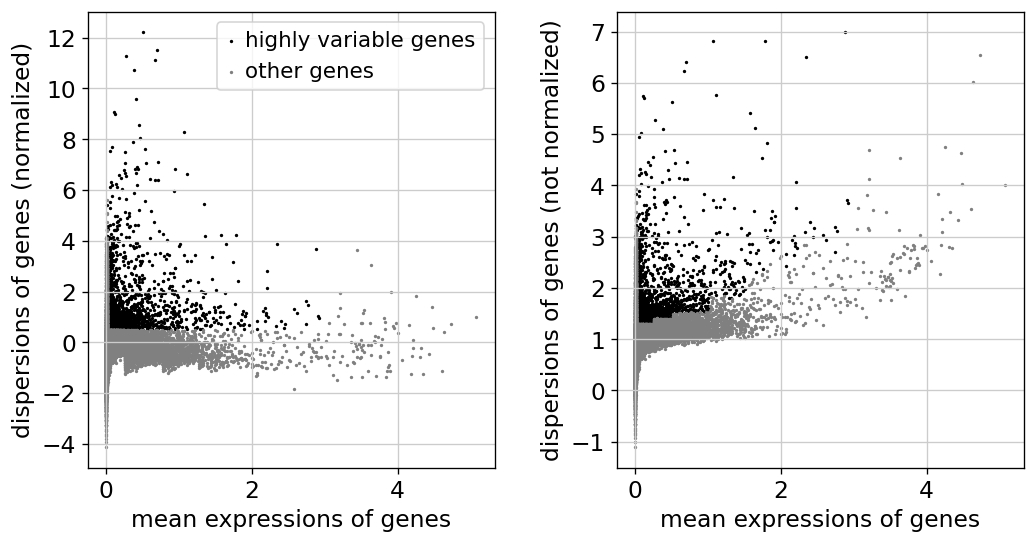

In [7]:
# 가변 유전자 계산
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d" % sum(adata.var.highly_variable))

# 가변 유전자 플롯
sc.pl.highly_variable_genes(adata)

# 스케일링(Z-점수)

유효한 특성(유전자)을 선택한 다음 차원 축소를 위해 PCA를 진행해야 합니다. 그런데 유전자마다 발현 수준이 모두 다르기 때문에 PCA를 진행하기 전에 각 유전자에 가중치를 부여해서 값을 스케일링해줘야 합니다. 일반적으로는 Z-점수 스케일링 방법을 많이 사용합니다. Z-점수 스케일링은 표준 편차가 1이고 평균이 0으로 하는 정규 분포가 되도록 값을 조정합니다.

In [8]:
# 데이터를 스케일링 합니다. 표준 편차 10이 넘는 값은 제거합니다.
sc.pp.scale(adata, max_value=10)
np.std(adata.X)

0.8287251754679223

# PCA(주성분 분석)

데이터의 차원을 축소하기 위해 PCA를 수행합니다. PCA는 사용되는 데이터에 따라 많은 유용한 응용과 해석이 가능합니다. scRNA seq의 경우 데이터의 유전자 발현 패턴에 따라 세포 유형을 구분하고자 합니다. scanpy에서 PCA를 실행하려면 `pca()` 함수를 사용합니다.

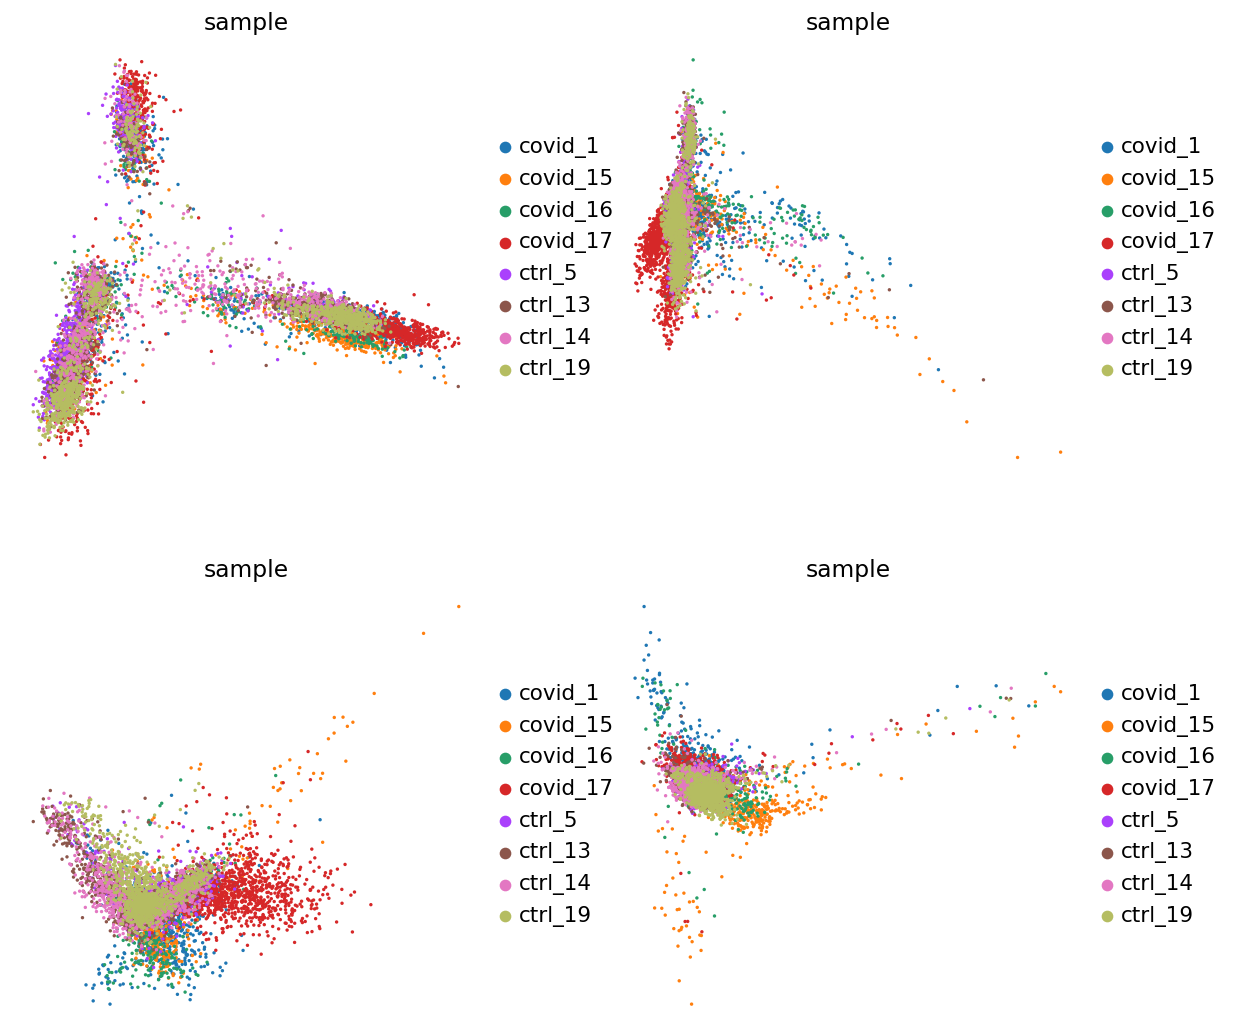

In [9]:
sc.tl.pca(adata, svd_solver="arpack")

# 그런 다음 첫 번째 주성분에 대한 플롯을 그려봅니다.
sc.pl.pca(adata, color="sample", components=["1,2", "3,4", "5,6", "7,8"], ncols=2)

각 PC에 가장 많이 기여하는 유전자를 식별하기 위해 다음과 같이 각 PC의 정보를 시각화 할 수 있습니다.

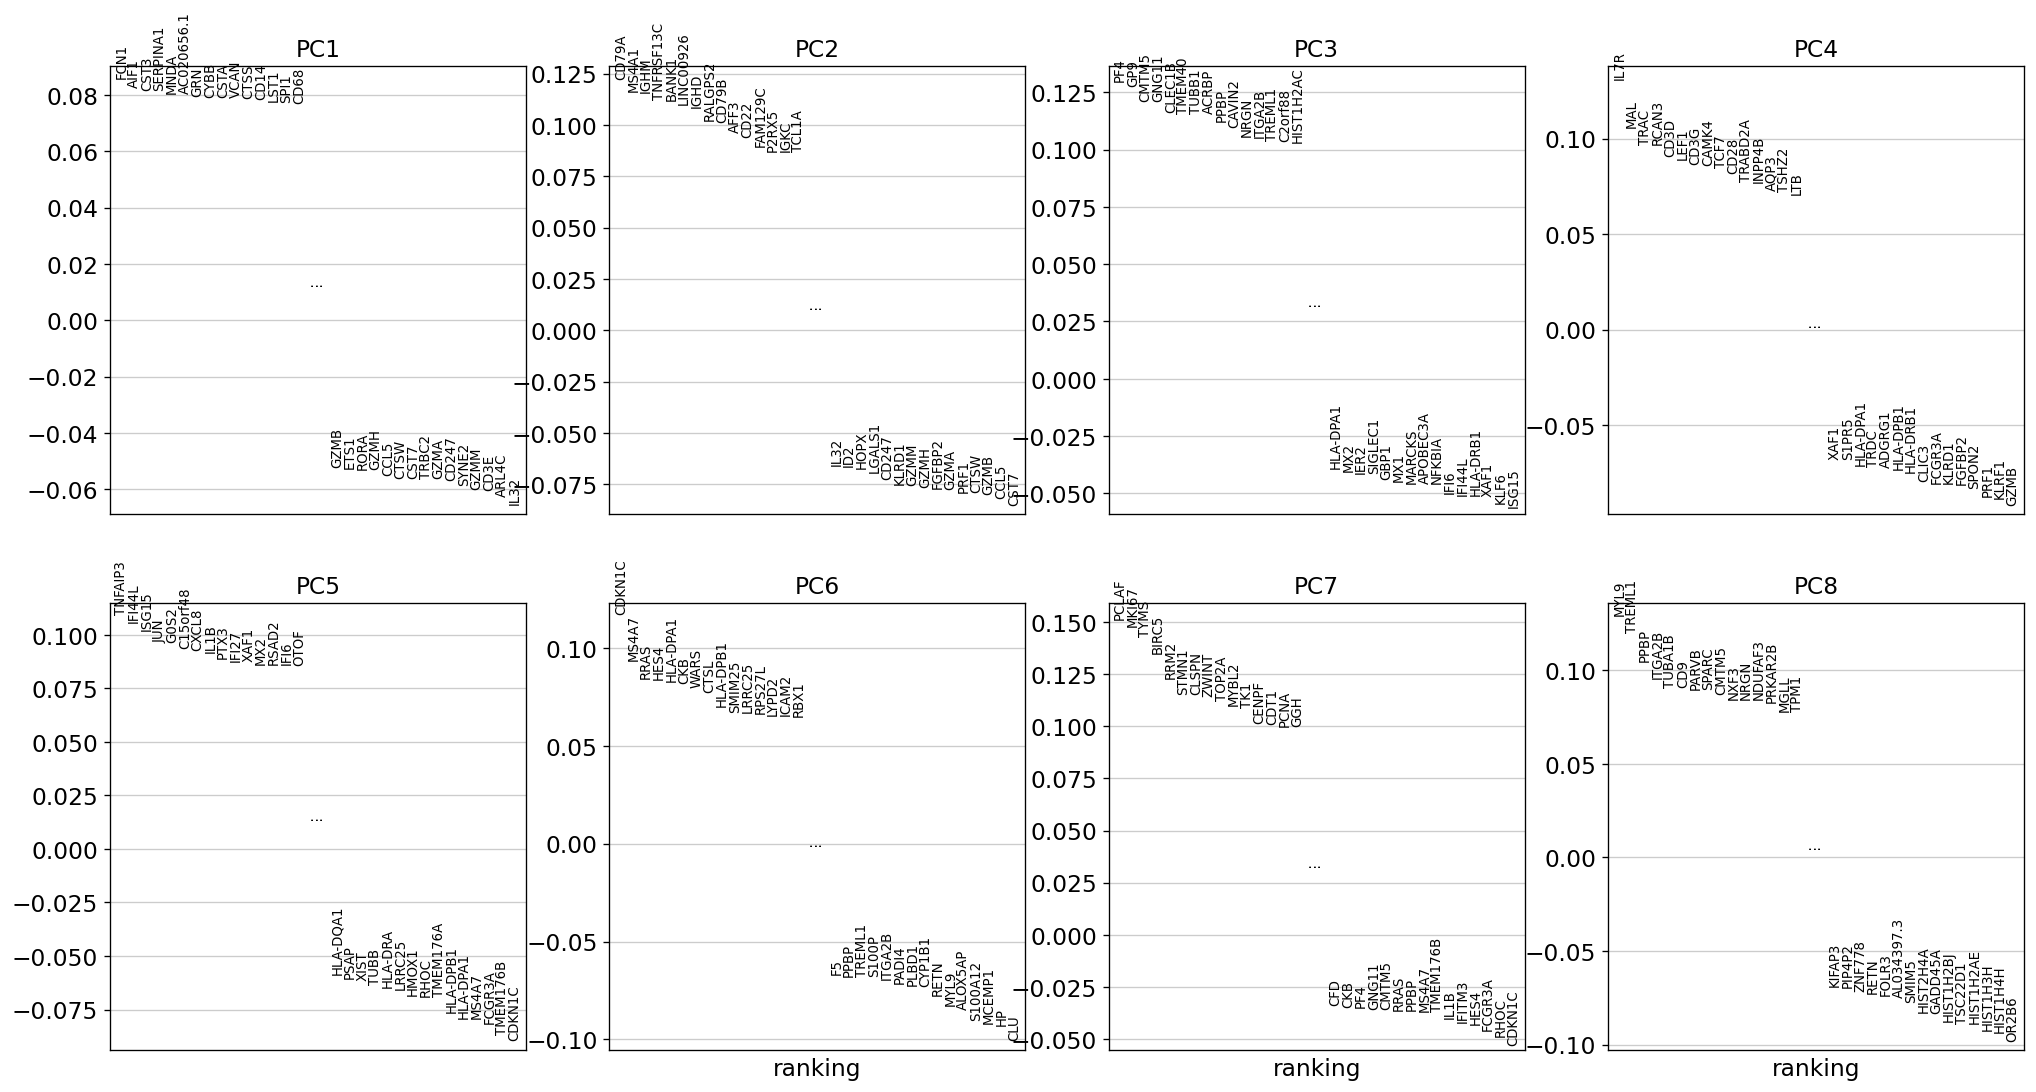

In [10]:
sc.pl.pca_loadings(adata, components=[1, 2, 3, 4, 5, 6, 7, 8])

또한 각 PC가 설명하는 분산량도 시각화 할 수 있습니다.

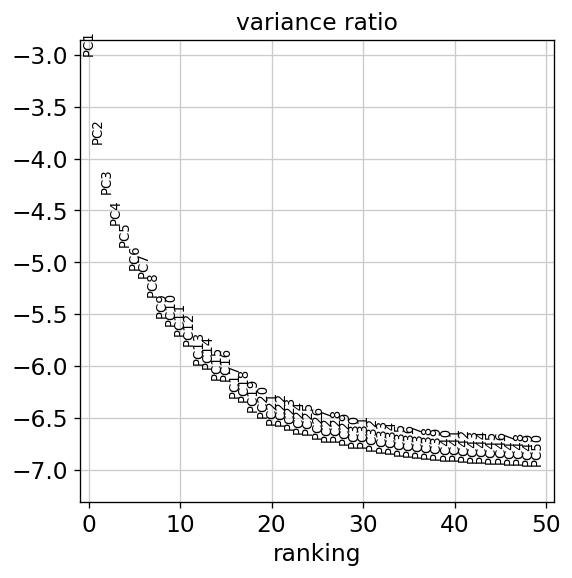

In [11]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

위 그림을 보면 상위 30개의 PC는 많은 정보를 보유하고 있는 반면 그 아래 PC는 점점 더 적은 정보를 포함하고 있음을 알 수 있습니다. 따라서 상위 30개 정도의 PC를 사용해 이후 tSNE, UMAP을 그려보겠습니다. 

:::{.callout-note}
희귀한 세포의 경우(예: 이 데이터셋에서는 혈소판 및 DC) 하위 PC에만 그런 정보가 포함되어 있을 수 있음으로 일반적으로 많은 PC를 사용해 진행하는 것이 권장됩니다.
:::

# tSNE

[tSNE](https://arxiv.org/abs/1301.3342)(t-distributed stochastic neighbor embedding)은 높은 차원의 복잡한 데이터를 2차원에 차원 축소하는 방법입니다. 시각화에 주로 사용하며 데이터 구조를 이해하는 데 도움을 줍니다. 샘플별로 색을 다르게 한 tSNE을 그려봅니다. 그렇게 하면 데이터 집합에 존재하는 배치의 효과를 명확하게 확인할 수 있습니다.

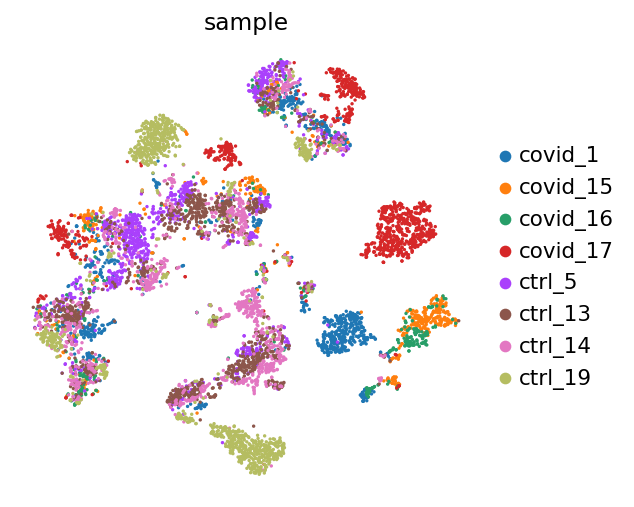

In [12]:
sc.tl.tsne(adata, n_pcs=30)  # PC의 갯수
sc.pl.tsne(adata, color="sample")

# UMAP

UMAP은 tSNE와 비교해서 속도가 빠르다는 장점과 데이터의 전체 구조를 더 잘 보존한다는 장점을 가지고 있습니다. 그래서 점점 [UMAP](https://arxiv.org/abs/1802.03426)이 많이 사용되는 추세입니다. 
scanpy에서 UMAP을 그리는 코드는 아래와 같습니다. 먼저 이웃(neighbors) 그래프를 계산하고 `tl.umap` 함수를 사용합니다.

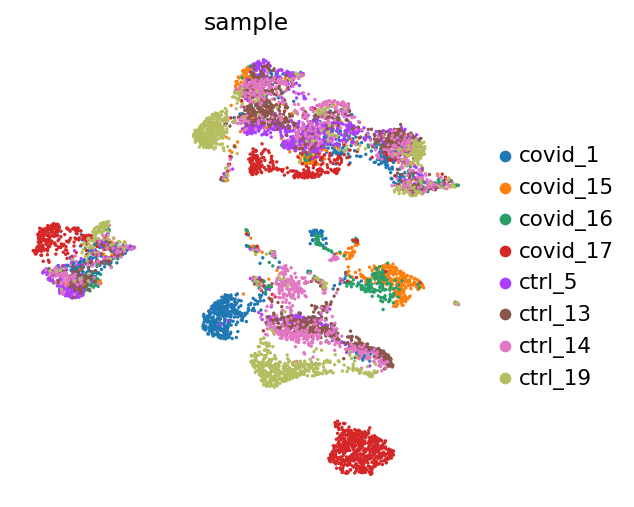

In [13]:
# 이웃 그래프 계산
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)

sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")

위 그림에서 tSNE만큼 뚜렷하지는 않지만 샘플에 의한 배치 효과가 여전히 뚜렷하게 보입니다. 특히 `covid_17` 샘플이 말이죠.

<Axes: title={'center': 'UMAP10'}, xlabel='UMAP3', ylabel='UMAP4'>

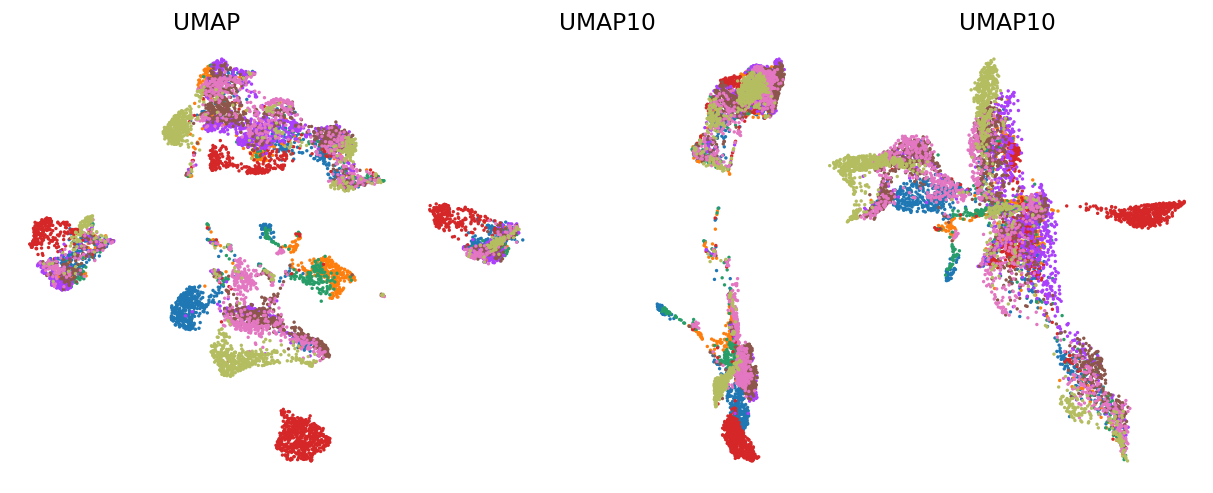

In [14]:
# 10개의 컴포넌트로 실행하고 새 객체에 저장하여 2D가 있는 유맵을 덮어쓰지 않도록 합니다.
umap10 = sc.tl.umap(adata, n_components=10, copy=True)
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)

sc.pl.umap(adata, color="sample", title="UMAP", show=False, ax=axs[0], legend_loc=None)
sc.pl.umap(
    umap10,
    color="sample",
    title="UMAP10",
    show=False,
    ax=axs[1],
    components=["1,2"],
    legend_loc=None,
)
sc.pl.umap(
    umap10,
    color="sample",
    title="UMAP10",
    show=False,
    ax=axs[2],
    components=["3,4"],
    legend_loc=None,
)

이웃 에지(neighbor edges)를 사용한 UMAP도 그릴 수도 있습니다.

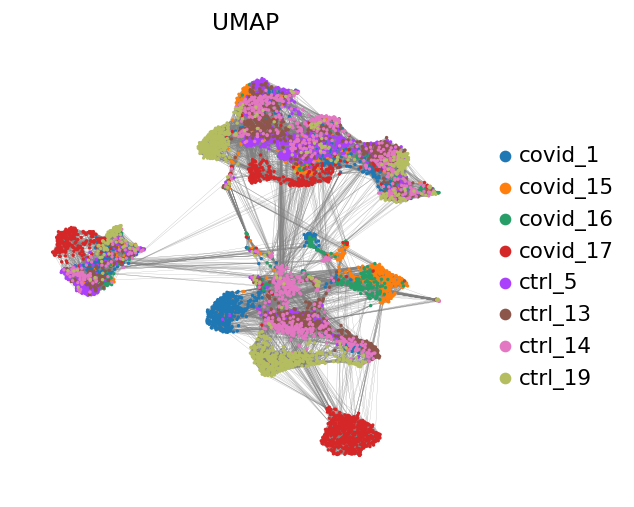

In [15]:
sc.pl.umap(adata, color="sample", title="UMAP", edges=True)

UMAP와 t-SNE는 둘 다 고차원 데이터를 저차원 공간에 시각화하기 위해 사용되는 차원 축소 기법입니다. 둘은 많은 유사점을 가지지만 다음과 같은 차이점도 있습니다.

1. 알고리즘:
   - t-SNE (t-Distributed Stochastic Neighbor Embedding): 고차원 공간에서 데이터 포인트 간의 유사성을 저차원 공간에서의 유사성으로 변환하는 데 주로 확률적 접근을 사용합니다. 저차원 공간에서 유사성을 표현하기 위해 t-분포를 사용하여 클러스터 간의 명확한 경계를 생성합니다.
   - UMAP (Uniform Manifold Approximation and Projection): 기하학적 및 위상수학적 이론에 기반하여 데이터의 기하학적 구조를 보존합니다. UMAP는 k-최근접 이웃을 사용하여 고차원 공간의 근접성을 유지하고 이를 저차원 공간으로 매핑합니다.

2. 속도와 확장성:
   - t-SNE는 데이터 포인트가 많아질수록 계산량이 급격히 증가하는 경향이 있습니다. 따라서 대규모 데이터셋에 적용하기가 어렵습니다.
   - UMAP는 일반적으로 t-SNE보다 빠르고, 대규모 데이터셋에도 더 잘 확장됩니다.

3. 보존되는 구조:
   - t-SNE는 로컬 구조(즉, 개별 클러스터 내부의 데이터 관계)에 집중하며, 전체 구조(클러스터 간의 관계를 잘 보존하지 못할 수 있습니다.
   - UMAP는 로컬 구조뿐만 아니라 전체 구조도 어느 정도 보존하려고 노력합니다.

4. 매개변수:
   - t-SNE의 주요 매개변수는 perplexity로, 이는 클러스터의 밀도에 영향을 미칩니다.
   - UMAP는 n_neighbors 및 min_dist와 같은 여러 매개변수를 가지며 로컬 및 전체 구조 보존에 영향을 미칩니다.


이제 PCA, UMAP, tSNE를 나란히 그려서 비교해보죠. 

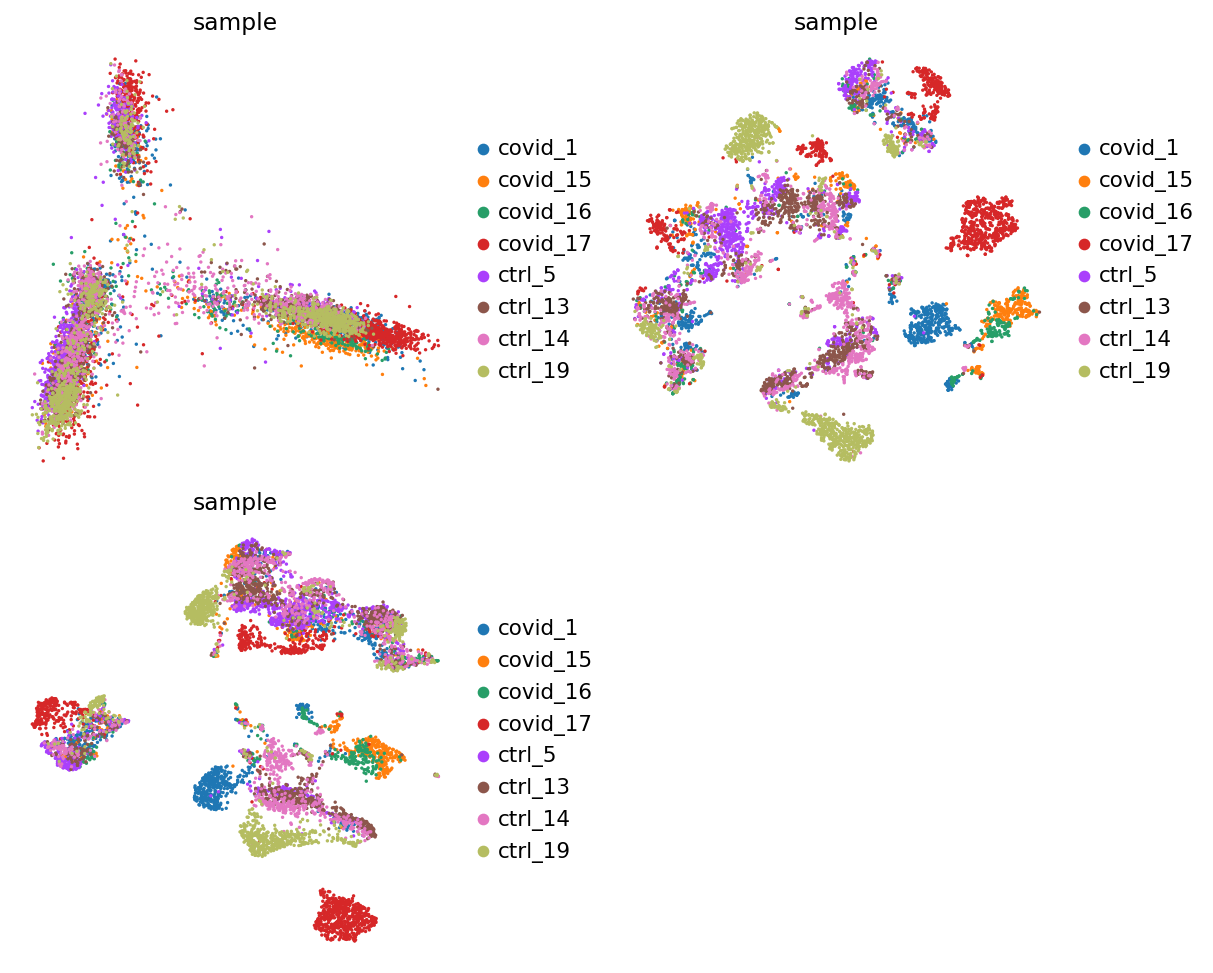

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
sc.pl.pca(adata, color="sample", components=["1,2"], ax=axs[0, 0], show=False)
sc.pl.tsne(adata, color="sample", components=["1,2"], ax=axs[0, 1], show=False)
sc.pl.umap(adata, color="sample", components=["1,2"], ax=axs[1, 0], show=False)
axs[-1, -1].axis("off")
plt.show()

위 결과 그림을 보면 일부 클러스터가 한 색상으로만 구성되어 있다는 것을 알 수 있습니다. 이것은 샘플의 배치 효과에 의한 것으로 데이터를 보정하지 않으면 잘못된 분석을 하게 됩니다.

# 배치 효과 보정

서로 다른 scRNA-seq 데이터를 합치면 샘플에 의한 배치 효과가 클러스터링에 많은 영향을 주곤합니다. 이런 문제를 해결하기 위해 몇 가지 방법들이 개발되었고 아래는 그 중 일부입니다.

Name | Language   |  Library |  Ref
---|---|---|---
CCA | R | Seurat | [Cell](https://www.sciencedirect.com/science/article/pii/S0092867419305598?via%3Dihub)
MNN | R/Python | Scater/Scanpy | [Nat. Biotech.](https://www.nature.com/articles/nbt.4091)
Conos | R | conos | [Nat. Methods](https://www.nature.com/articles/s41592-019-0466-z?error=cookies_not_supported&code=5680289b-6edb-40ad-9934-415dac4fdb2f)
Scanorama| Python | scanorama | [Nat. Biotech.](https://www.nature.com/articles/s41587-019-0113-3)

여기에서는 `BBKNN과` `Scanorama` 기법을 사용해 배치 효과를 제거해보겠습니다. 먼저, 배치 효과를 제거하기 앞서 데이터(`adata.X`에 들어있는 값)가 스케일링되어 있기에 아래 코드를 통해 로그 정규화된 값으로 다시 되돌립니다.

In [17]:
adata.X = adata.layers["log1p"].copy()

# 행렬이 정규화된 카운트처럼 보이는지 확인.
print(adata.X[1:10, 1:10])

  (0, 3)	0.7826338246821452
  (7, 6)	1.1311041336746985


최소 2개의 데이터 세트에서 가변적인 유전자를 모두 선택해서 분석에 사용합니다.

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key="sample")

var_select = adata.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]

print(f"가변 유전자의 수: {len(var_genes)}")

가변 유전자의 수: 4268


## BBKNN

먼저 BBKNN(Batch Balanced KNN)을 실행해 보겠습니다. BBKNN은 빠르고 직관적인 배치 효과 제거 도구로 scanpy 워크플로우에서 바로 사용할 수 있습니다. 또한 `scanpy.pp.neighbors()` 함수 대신에 사용할 수 있습니다. 더 자세한 내용은 [BBKNN](https://scanpy.readthedocs.io/en/latest/generated/scanpy.external.pp.bbknn.html#scanpy-external-pp-bbknn) 문서를 참조하세요.

In [19]:
adata_bbknn = adata.copy()
neighbors_within_batch = 25 if adata.n_obs > 100000 else 3

bbknn.bbknn(adata_bbknn, batch_key="sample", neighbors_within_batch=neighbors_within_batch)

sc.tl.umap(adata_bbknn)
sc.tl.tsne(adata_bbknn)

이제 통합되지 않은 공간과 통합된 공간의 축소된 치수를 그릴 수 있습니다.

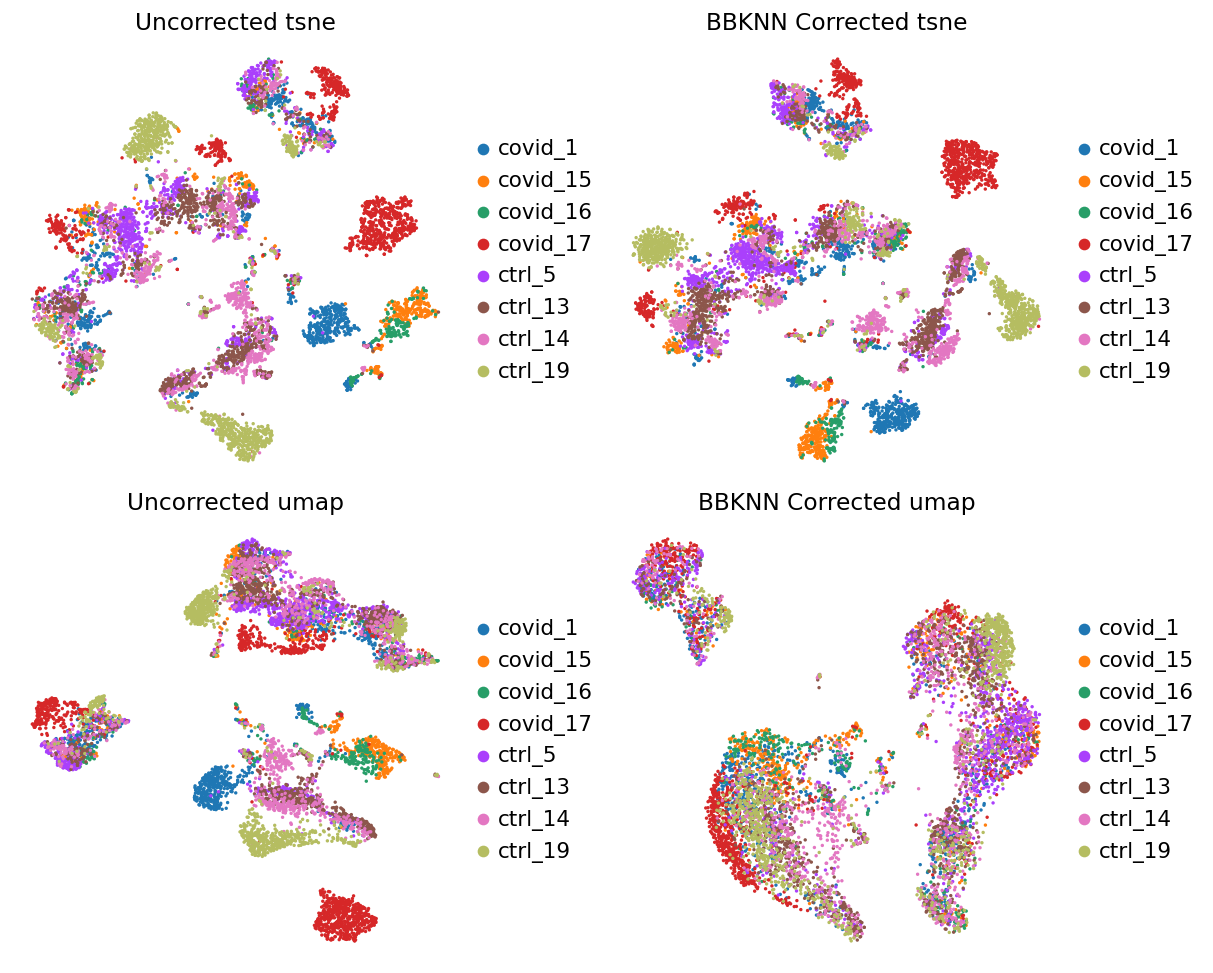

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
sc.pl.tsne(adata_bbknn, color="sample", title="BBKNN Corrected tsne", ax=axs[0, 1], show=False)
sc.pl.tsne(adata, color="sample", title="Uncorrected tsne", ax=axs[0, 0], show=False)
sc.pl.umap(adata_bbknn, color="sample", title="BBKNN Corrected umap", ax=axs[1, 1], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1, 0], show=False)
plt.show()

## Scanorama

[Scanorama](https://github.com/brianhie/scanorama)는 scRNA-seq 데이터 세트의 일괄 보정 및 통합을 사용할 수 있도록 설계되었습니다. Scanorama를 통한 보정의 결과는 다른 도구의 입력으로 사용하여 scRNA-seq 클러스터링, 시각화 및 분석에 사용할 수 있습니다. 
이제 [Scanorama](https://github.com/brianhie/scanorama)도 사용해 보겠습니다. 먼저, 각 데이터 세트에서 개별 AnnData 객체를 만들어야 합니다.

In [21]:
# 배치별로 개체를 분할합니다.
batches = adata.obs["sample"].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs["sample"] == batch,]

# 개별 데이터 집합을 처음에 정의한 가변 유전자로 하위 집합합니다.
alldata2 = {}
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:, var_genes]

# AnnData 객체 목록으로 변환
adatas = list(alldata2.values())

# scanorama.integrate 실행
scanorama.integrate_scanpy(adatas, dimred=50, verbose=False)

# scanorama는 adatas의 각 데이터 집합에서 수정된 행렬을 adata.obsm에 추가합니다.
adatas[0].obsm["X_scanorama"].shape

covid_1
covid_15
covid_16
covid_17
ctrl_5
ctrl_13
ctrl_14
ctrl_19
Found 4268 genes among all datasets


(874, 50)

In [22]:
# 모든 통합 행렬을 가져옵니다.
scanorama_int = [ad.obsm["X_scanorama"] for ad in adatas]

# 하나의 행렬로 만듭니다.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# AnnData 객체에 추가하려면 먼저 새 객체를 만듭니다.
adata_sc = adata.copy()
adata_sc.obsm["Scanorama"] = all_s

(7227, 50)


In [23]:
# tsne 과 umap을 그립니다.
sc.pp.neighbors(adata_sc, n_pcs=30, use_rep="Scanorama")
sc.tl.umap(adata_sc)
sc.tl.tsne(adata_sc, n_pcs=30, use_rep="Scanorama")

이제 통합되지 않은 공간과 통합된 공간을 축소한 차원을 그릴 수 있습니다.

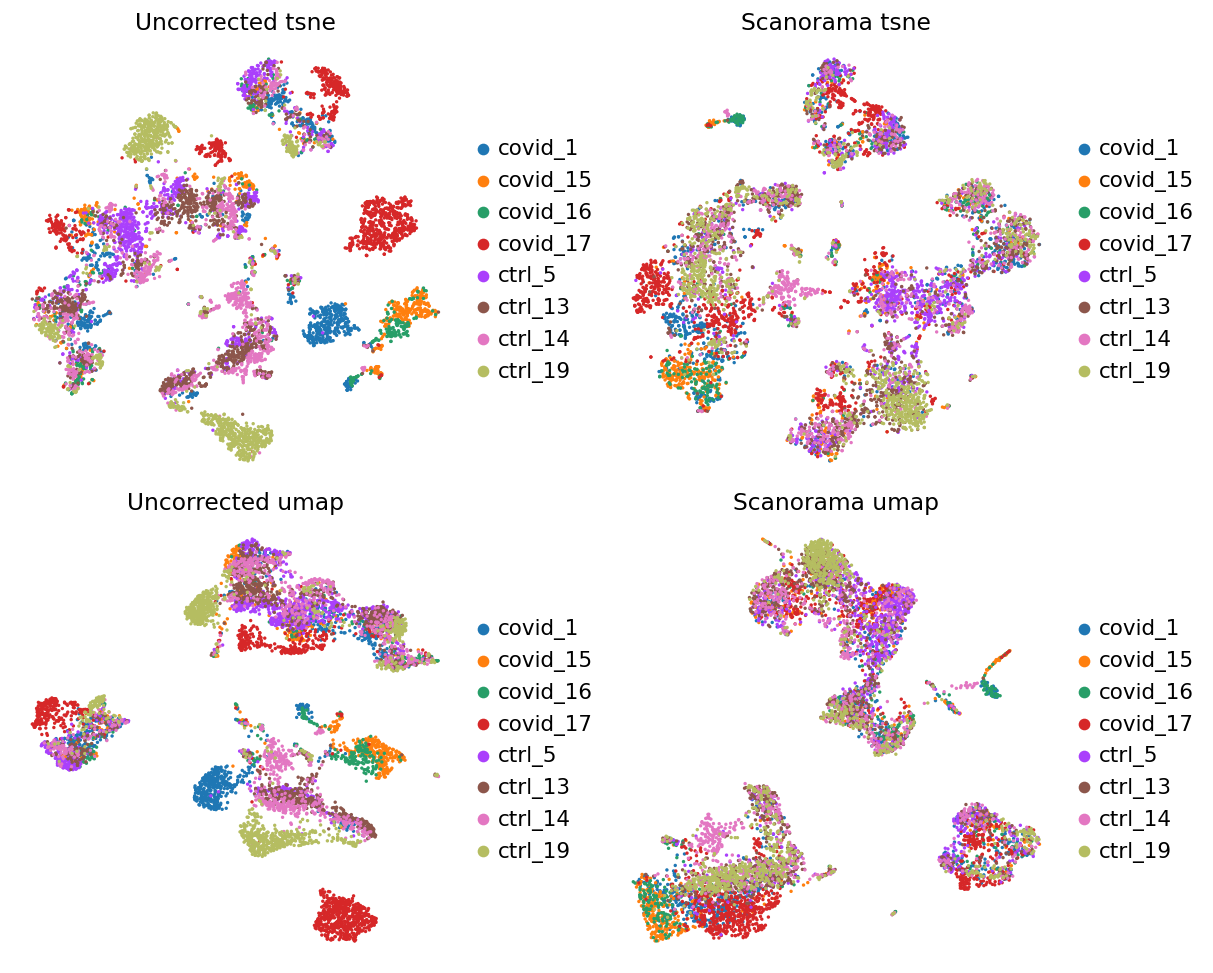

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
sc.pl.tsne(adata, color="sample", title="Uncorrected tsne", ax=axs[0, 0], show=False)
sc.pl.tsne(adata_sc, color="sample", title="Scanorama tsne", ax=axs[0, 1], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1, 0], show=False)
sc.pl.umap(adata_sc, color="sample", title="Scanorama umap", ax=axs[1, 1], show=False)
plt.show()

## 결과 살펴보기

이제 세 가지 통합 방법을 나란히 사용하여 UMAP을 그려보겠습니다.

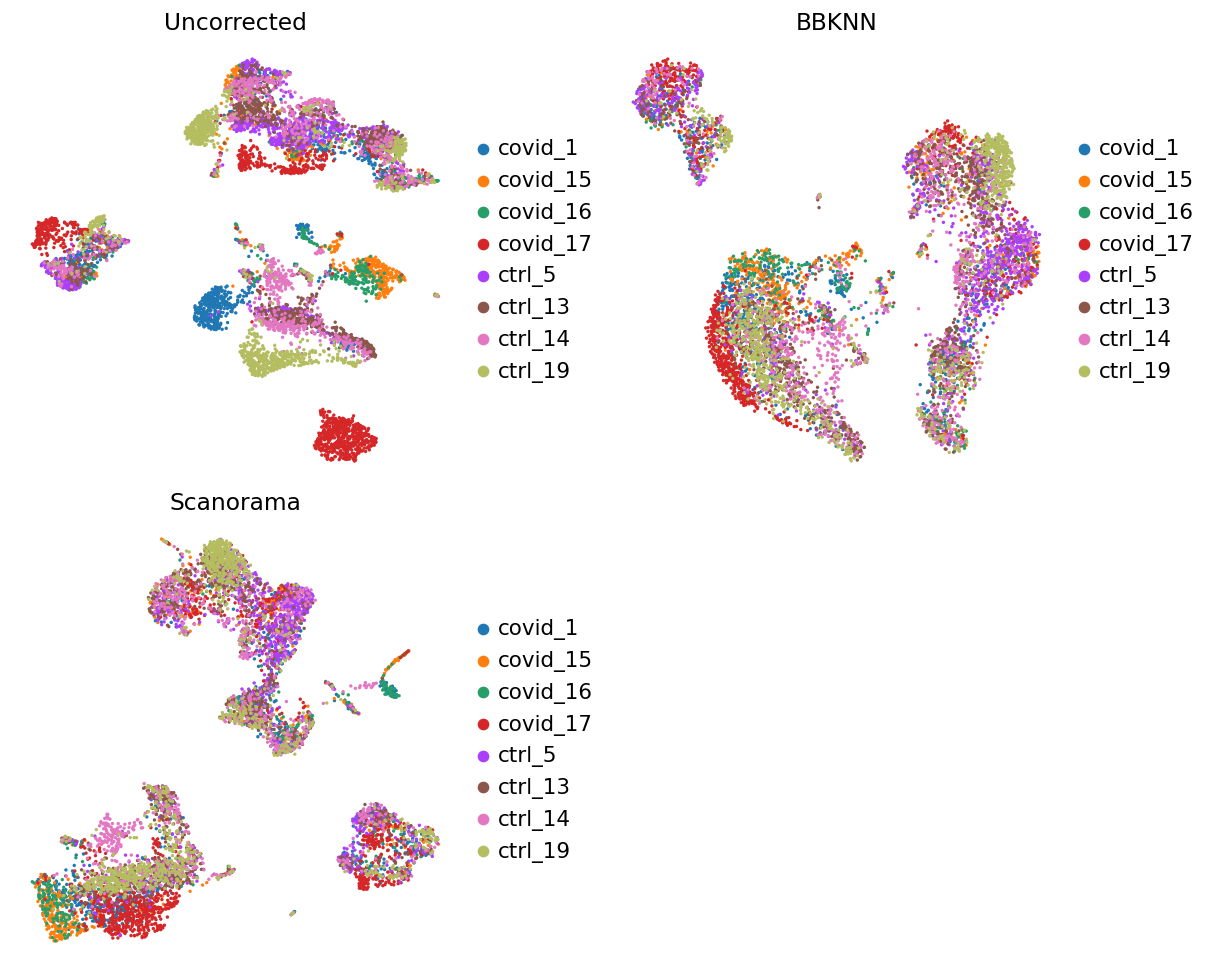

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
sc.pl.umap(adata, color="sample", title="Uncorrected", ax=axs[0, 0], show=False)
sc.pl.umap(adata_bbknn, color="sample", title="BBKNN", ax=axs[0, 1], show=False)
sc.pl.umap(adata_sc, color="sample", title="Scanorama", ax=axs[1, 0], show=False)
axs[-1, -1].axis("off")
plt.show()

배치 효과 제거를 위해 사용할 수 있는 다양한 방법이 있으며, 각 방법에는 장단점이 있습니다. 가장 적합한 방법을 선택하는 데에는 데이터의 특성과 분석 목표에 따라 달라질 수 있습니다. 그러니 다양한 방법을 시도하여 데이터 특성에 가장 잘 맞는 방법을 찾는 것이 중요합니다.

:::{.callout-note}

배치 효과가 잘 제거되었는지 어떻게 평가할 수 있을까요? 크게 두가지 방법이 있습니다.

1. 시각적 평가: UMAP 플롯을 통해 배치가 잘 섞여 있는지 시각적으로 확인합니다. 배치 간의 구분이 사라지면 배치 효과가 잘 제거된 것입니다.
2. 실루엣 스코어: 높은 실루엣 스코어는 잘 클러스터링된 데이터를 의미합니다. 배치 효과 제거 전후의 실루엣 스코어를 비교하여 배치 효과 제거의 효과를 평가합니다.

:::

시각적 평가를 통해 어떤 도구가 배치 효과 보정을 잘 했는지 살펴보면, 아무래도 Scanorma로 한 것이 좋아보입니다. 이후의 분석은 `adata_sc` 객체를 가지고 진행하겠습니다.


# 데이터 저장하기

지금까지 작업한 내용이 들어있는 `adata_sc` 객체를 `h5ad`파일로 저장합니다.

In [26]:
save_file = "./output/covid/results/scanpy_covid_qc_dr_sc.h5ad"
adata_sc.write_h5ad(save_file, compression="gzip")

# 나가며

이번 글에서는 scRNAseq 데이터 분석에서 중요한 두 가지 주제인 차원 축소와 배치 효과 제거에 대해 다루었습니다. 차원 축소를 통해 데이터를 효과적으로 시각화하고 해석할 수 있었으며 배치 효과 제거 도구를 사용하는 방법을 배웠습니다. 다음 글에서는 더 흥미로운 주제를 가지고 다시 찾아뵙겠습니다.